In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


df = pd.read_csv("train.csv")

In [2]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
median_value = df['TotalCharges'].median()
df['TotalCharges'] = df['TotalCharges'].fillna(median_value)

In [3]:
df.replace({'TotalCharges': {' ': np.nan}}, inplace=True)
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [4]:
def find_outliers_and_replace(df, whis=1.5):
    """
    주어진 데이터프레임에서 숫자형 열들에 대해 IQR 방식을 통해 이상치를 찾아
    이상치 값을 최소 또는 최대 허용 범위 값으로 대체하는 함수.
    이진 변수는 이상치 처리에서 제외.
    
    Parameters:
    - df: 데이터프레임
    - whis: IQR의 배수로, 기본값은 1.5
    
    Returns:
    - 이상치가 대체된 데이터프레임
    """
    # 복사본 생성
    df_copy = df.copy()
    
    # 숫자형 열만 선택
    numeric_columns = df_copy.select_dtypes(include='number').columns
    
    for column_name in numeric_columns:
        # 이진 변수인지 확인 (고유 값이 2개만 있는 경우)
        unique_values = df_copy[column_name].nunique()
        if unique_values == 2:
            # 이진 변수인 경우 이상치 처리를 생략
            continue

        # 1사분위수(Q1)와 3사분위수(Q3) 계산
        q1, q3 = df_copy[column_name].quantile([0.25, 0.75])
        iqr = q3 - q1

        # 하한과 상한 계산
        lower_bound = q1 - iqr * whis
        upper_bound = q3 + iqr * whis

        # 이상치를 하한과 상한으로 대체
        df_copy[column_name] = df_copy[column_name].apply(
            lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
        )
    
    return df_copy

In [5]:


label_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
label_encoder = LabelEncoder()

for col in label_cols:
    df[col] = label_encoder.fit_transform(df[col])

df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod', 'MultipleLines',
                                 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                 'StreamingTV', 'StreamingMovies'])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# X, y 데이터 분
X = df.drop(columns=['Churn', 'customerID']).values
y = df['Churn'].values
y = y.reshape(-1, 1)
X.shape, y.shape

# 데이터 train, test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=0)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

trainset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
testset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=128)
len(train_loader), len(test_loader)

(44, 12)

In [7]:
import os
os.makedirs("module", exist_ok=True)

In [8]:
%%writefile module/train.py

from sklearn.metrics import f1_score
import time
import torch

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps
        test_accuracy /= size
    return test_loss, test_accuracy
    
def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size 
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    [parameter]
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: binary
    [return]
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    size = len(dataloader.dataset) 

    all_preds = []  
    all_targets = []  
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if mode == "binary":
            pred_label = (pred >= 0.5).type(torch.int32) 
        else:
            pred_label = torch.argmax(pred, axis=-1)

        all_preds.extend(pred_label.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    f1 = f1_score(all_targets, all_preds, average="binary" if mode == "binary" else "macro")
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy, f1


def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, save_model_path=None, early_stopping=True, patience=10, device='cpu', mode='binary'):
   
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []

    best_epoch = 0
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    best_f1 = 0.0
    
    if save_best_model:
        best_score_save = float('inf')

    if early_stopping:
        trigger_count = 0
        best_score_es = float('inf')
    
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        train_loss, train_accuracy, f1 = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)

        ## 제일좋은 epoch이면 저장.
        if val_loss < best_val_loss: 
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1
            if save_best_model and save_model_path is not None:
                torch.save(model.state_dict(), save_model_path)
                
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f} F1 Score: {f1:.5f}")
        print('='*100)
        
        if save_best_model and save_model_path is not None:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss

        
        ## early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    print(f"Best Epoch: {best_epoch} - Validation Loss: {best_val_loss:.5f}, Validation Accuracy: {best_val_accuracy:.5f}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Overwriting module/train.py


In [9]:
%%writefile module/utils.py

import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

Overwriting module/utils.py


In [12]:
epochs = 1000
lr = 0.01

######### 모델 정의
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(40, 32)
        self.lr2 = nn.Linear(32, 8)
        self.lr3 = nn.Linear(8, 1) 
        self.relu = nn.ReLU()
        self.logistic = nn.Sigmoid()  

    def forward(self, X):
        X = self.lr1(X)
        X = self.relu(X)
        X = self.lr2(X)
        X = self.relu(X)
        # 출력 Layer
        output = self.lr3(X)
        output = self.logistic(output)
        return output
        
model = Model().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

from module.train import fit

train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader,
    model, loss_fn, optimizer,
    epochs,
    patience=10,
    device=device,
    mode="binary"
)

Epoch[1/1000] - Train loss: 0.43272 Train Accucracy: 0.79766 || Validation Loss: 0.44876 Validation Accuracy: 0.78850 F1 Score: 0.52956
Epoch[2/1000] - Train loss: 0.42642 Train Accucracy: 0.80263 || Validation Loss: 0.43711 Validation Accuracy: 0.79063 F1 Score: 0.58466
Epoch[3/1000] - Train loss: 0.44050 Train Accucracy: 0.79002 || Validation Loss: 0.44804 Validation Accuracy: 0.77644 F1 Score: 0.59489
Epoch[4/1000] - Train loss: 0.41362 Train Accucracy: 0.80848 || Validation Loss: 0.42716 Validation Accuracy: 0.78566 F1 Score: 0.58992
Epoch[5/1000] - Train loss: 0.40444 Train Accucracy: 0.81150 || Validation Loss: 0.41421 Validation Accuracy: 0.79560 F1 Score: 0.60281
Epoch[6/1000] - Train loss: 0.40499 Train Accucracy: 0.80955 || Validation Loss: 0.41337 Validation Accuracy: 0.79418 F1 Score: 0.60155
Epoch[7/1000] - Train loss: 0.40043 Train Accucracy: 0.81044 || Validation Loss: 0.41192 Validation Accuracy: 0.78921 F1 Score: 0.60787
Epoch[8/1000] - Train loss: 0.39699 Train Accucr

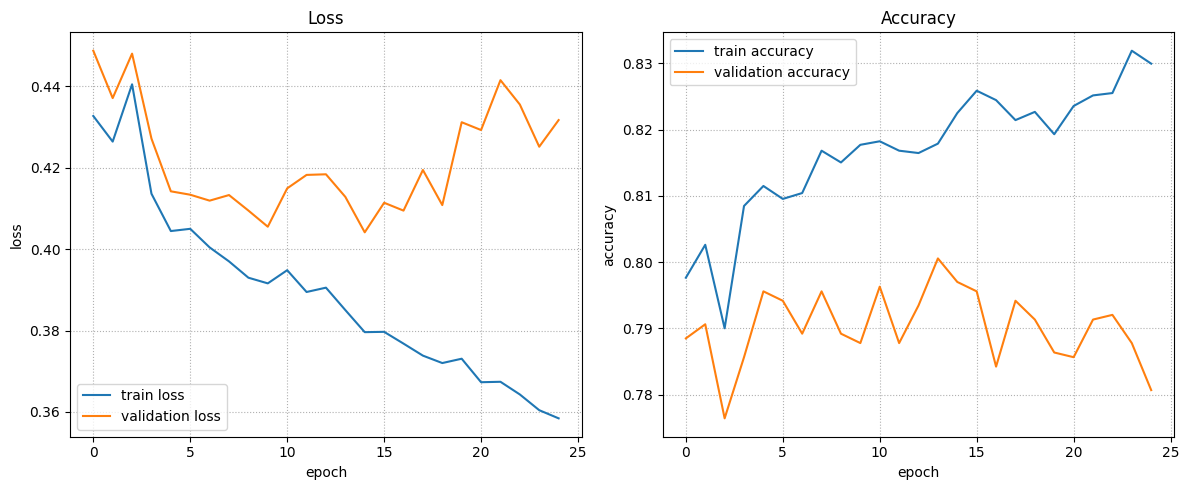

In [13]:
from module.utils import plot_fit_result

plot_fit_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)